My some early experiments with TF2 models (from TF tutorials)

In [1]:
import tensorflow as tf
from datetime import datetime

%load_ext tensorboard

In [3]:
tf.executing_eagerly()

True

In [3]:
# Simple dense layer

class Dense(tf.Module):
  def __init__(self, in_features, out_features, name=None):
    super().__init__(name=name)
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name='w')
    self.b = tf.Variable(tf.zeros([out_features]), name='b')
  def __call__(self, x):
    y = tf.matmul(x, self.w) + self.b
    return tf.nn.relu(y)

class SimpleSeqModel(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.dense1 = Dense(in_features=3, out_features=3)
        self.dense2 = Dense(in_features=3, out_features=2)

    def __call__(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [4]:
simpleModel = SimpleSeqModel(name="my_first_model")
res = simpleModel(tf.constant([[2.0, 2.0, 2.0]]))
print(res)

tf.Tensor([[0.       5.988944]], shape=(1, 2), dtype=float32)


In [13]:
simpleModel.variables


(<tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.09610817, -0.6794228 , -1.0882269 ],
        [-0.9351774 ,  1.012929  , -0.9975611 ],
        [ 0.6609816 ,  1.0810384 ,  0.5840033 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.5184649 ,  0.23479697],
        [ 1.647145  , -1.3691983 ],
        [ 1.2820375 ,  0.20276329]], dtype=float32)>)

Checkpoints

In [14]:
chkp_path = "checkpoints/my_chpk"
chkp = tf.train.Checkpoint(model=simpleModel)
chkp.write(chkp_path)

'checkpoints/my_chpk'

In [15]:
tf.train.list_variables(chkp_path)

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/dense1/b/.ATTRIBUTES/VARIABLE_VALUE', [3]),
 ('model/dense1/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 3]),
 ('model/dense2/b/.ATTRIBUTES/VARIABLE_VALUE', [2]),
 ('model/dense2/w/.ATTRIBUTES/VARIABLE_VALUE', [3, 2])]

In [17]:
new_model = SimpleSeqModel()
new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore("checkpoints/my_chpk")
res = new_model(tf.constant([[2.0, 2.0, 2.0]]))
print(res)

tf.Tensor([[4.65992 0.     ]], shape=(1, 2), dtype=float32)


Saving functions

In [33]:
class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=3, out_features=3)
    self.dense_2 = Dense(in_features=3, out_features=2)

  @tf.function
  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a model with a graph!
my_model = MySequentialModule(name="the_model")
print(my_model(tf.constant([[3.0, 3.0, 3.0]])))
print(my_model([[[3.0, 3.0, 3.0], [3.0, 3.0, 3.0]]]))


tf.Tensor([[8.809925  2.0826237]], shape=(1, 2), dtype=float32)
tf.Tensor(
[[[8.809925  2.0826237]
  [8.809925  2.0826237]]], shape=(1, 2, 2), dtype=float32)


In [31]:
# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "logs/func/%s" % stamp
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace
# Otherwise the summary will not see the graph.
new_model = MySequentialModule()

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
tf.profiler.experimental.start(logdir)
# Call only one tf.function when tracing.
z = print(new_model(tf.constant([[2, 2, 2]])))
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

AlreadyExistsError: Another profiler is running.

In [42]:
tf.constant([[2, 2, 2],[2, 2, 2]]) + tf.constant([[1, 1, 1]])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[3, 3, 3],
       [3, 3, 3]])>

In [9]:
%tensorboard --logdir logs/func

Launching TensorBoard...

In [34]:
tf.saved_model.save(my_model, "the_saved_model")

INFO:tensorflow:Assets written to: the_saved_model\assets


In [35]:
my_model = tf.saved_model.load("the_saved_model")

In [39]:
# print(my_model([[2.0, 2.0, 2.0]]))
print(my_model(tf.constant([[3.0, 3.0, 3.0]])))




tf.Tensor([[8.809925  2.0826237]], shape=(1, 2), dtype=float32)


Training
(Example from tf)

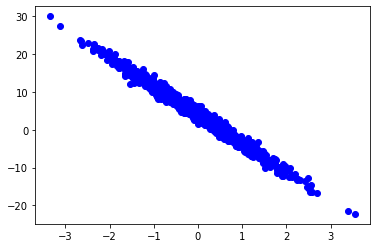

In [4]:
import matplotlib.pyplot as plt
# The actual line
TRUE_W = -7.5
TRUE_B = 4.0

NUM_EXAMPLES = 1000
# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])
# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])
# Calculate y
y = x * TRUE_W + TRUE_B + noise
plt.scatter(x, y, c="b")
plt.show()

In [6]:
import numpy as np
import random

def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

class MyLinerModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(random.random())
    self.b = tf.Variable(random.random())

  def call(self, x, **kwargs):
    return self.w * x + self.b

In [11]:
def train_model(model, x, y, lr = 0.01, epoches = 30):
    for epoch in range(epoches):
        with tf.GradientTape() as tape:
            loss_ = loss(y, model(x))
        dw, db = tape.gradient(loss_, [model.w, model.b])
        model.w.assign_sub(lr * dw)
        model.b.assign_sub(lr * db)

def train_loop() -> MyLinerModel:
    attempts = range(10)
    model = MyLinerModel()
    Ws, Bs = [], []
    print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" % (model.w, model.b, loss(y, model(x))))
    for attempt in attempts:
        train_model(model, x, y)
        Ws.append(model.w.numpy())
        Bs.append(model.b.numpy())
        current_loss = loss(y, model(x))
        print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" % (attempt, Ws[-1], Bs[-1], current_loss))

    plt.plot(attempts, Ws, "r",
             attempts, Bs, "b")

    plt.plot([TRUE_W] * len(attempts), "r--",
             [TRUE_B] * len(attempts), "b--")
    plt.legend(["W", "b", "True W", "True b"])
    plt.show()
    return model

Starting: W=0.06 b=0.21, loss=73.99551
Epoch  0: W=-3.41 b=2.00, loss=22.14204
Epoch  1: W=-5.29 b=2.94, loss=7.10399
Epoch  2: W=-6.30 b=3.44, loss=2.74088
Epoch  3: W=-6.85 b=3.70, loss=1.47439
Epoch  4: W=-7.15 b=3.84, loss=1.10658
Epoch  5: W=-7.31 b=3.91, loss=0.99971
Epoch  6: W=-7.40 b=3.95, loss=0.96864
Epoch  7: W=-7.45 b=3.97, loss=0.95961
Epoch  8: W=-7.48 b=3.98, loss=0.95698
Epoch  9: W=-7.49 b=3.99, loss=0.95621


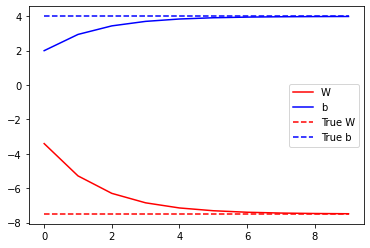

In [12]:
trained = train_loop()

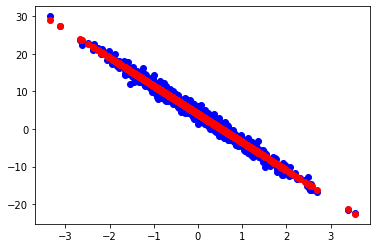

Current loss: 0.956210


In [13]:
plt.scatter(x, y, c="b")
plt.scatter(x, trained(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(trained(x), y).numpy())

In [14]:
keras_model = MyLinerModel()
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                    loss= tf.keras.losses.mean_squared_error,
                    run_eagerly=False)

In [20]:
keras_model.fit(x, y, epochs=10, batch_size=100)


Epoch 1/10
10/10 [==============================] - 0s 1ms/step - loss: 0.9562
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.9562
Epoch 3/10
10/10 [==============================] - 0s 666us/step - loss: 0.9562
Epoch 4/10
10/10 [==============================] - 0s 778us/step - loss: 0.9564
Epoch 5/10
10/10 [==============================] - 0s 889us/step - loss: 0.9561
Epoch 6/10
10/10 [==============================] - 0s 889us/step - loss: 0.9562
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.9563
Epoch 8/10
10/10 [================